## WOA13 Temperature and Salinity Bias

* This notebook plots the zonal average T/S bias relative to WOA18
* Author: John Krasting

In [1]:
# For testing and development purposes, enter a start year, end year, and
# an dora id number to analyze. The value of dora_id can also be a direct
# path to a /pp directory.

config = {
    "startyr": 1998,
    "endyr": 2017,
    "dora_id": "odiv-411",
}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
print(str(config))

{'startyr': 1998, 'endyr': 2017, 'dora_id': 'odiv-411'}


### Import Python Modules

In [4]:
import glob
import subprocess
import os
import datetime

import doralite
import matplotlib.pyplot as plt
import momgrid as mg
import momlevel as ml
import numpy as np
import xarray as xr

import cmip_basins
import momgrid.VerticalSplitScale as VerticalSplitScale

from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Define Local Parameters

In [6]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

if config["dora_id"] is not None:
    experiment =  doralite.dora_metadata(config["dora_id"])
    pathPP = experiment["pathPP"]
    expName = experiment["expName"]
else:
    raise ValueError("Experiment must be defined")

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(end) if end is not None else 9999

### Determine What Files to Load

In [7]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varname = "ann"

chunk = "annual_5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/av/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1998-2002.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2003-2007.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2008-2012.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20240508/om5_b05_Roquet_noArcticHenyey/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2013-2017.ann.nc


### DMgetting Files

Dora cannot issue calls to dmget

In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Establish a Dictionary to Store Scalar Metrics

In [9]:
stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
}
stats_dict["results"] = {}
stats_dict

{'metadata': {'expName': 'om5_b05_Roquet_noArcticHenyey',
  'created': '2024-09-18T16:55:58.339545'},
 'results': {}}

In [10]:
def yz_stats(arr,y,z):
    ybnds = momgrid.util.infer_bounds(y.values)
    dy = np.abs(ybnds[1::] - ybnds[0:-1]) #distance in degrees
    dy = dy * (40075000 / 360)  # Earth's circumference divided by 360 degrees
    dz = np.abs(z.values[1::] - z.values[0:-1])
    weight = np.multiply(*np.meshgrid(dy,dz))

    masked_arr = np.ma.array(arr.values, mask=np.isnan(arr))
    mean = np.ma.average(masked_arr, weights=weight)
    max = masked_arr.max()
    min = masked_arr.min()

    se = masked_arr * masked_arr
    mse = np.ma.average(se, weights=weight)
    rmse = np.sqrt(mse)

    stats = {
        "bias": mean,
        "min": min,
        "max": max,
        "rmse": rmse,
    }

    # Limit to 4 significant digits
    stats = {k:f"{v:.4g}" for k,v in stats.items()}
    
    # Stats string
    stats_str = f"min= {min:.4g}  max= {max:.4g}\nmean= {mean:.4g}  rmse={rmse:.4g}"
    
    return (stats, stats_str)

In [11]:
def cmap_normed(levels, cmap="viridis", white_center=False):

    base_cmap = plt.get_cmap(cmap)
    nlev = len(levels-1)    
    colors = base_cmap(np.linspace(0, 1, nlev))
    
    if white_center:
            # Set the middle interval color to white
            mid_index = (nlev - 1) // 2
            colors[mid_index] = (1, 1, 1, 1)
    
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N, clip=True)

    return (cmap, norm)

### Load model data and grid

In [12]:
# Open the dataset and retain only the variables needed for analysis
ds = xr.open_mfdataset(filelist, use_cftime=True)
ds = ds.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))
ds = xr.Dataset({
    "thetao":ds.thetao,
    "so":ds.so,
    "z_i":ds.z_i,
})

# Save interfaces to add back in after passing through MOMGrid
z_i = ds["z_i"]

# Take the time mean
start_time = ds.time[0]
end_time = ds.time[-1]
ds = ds.mean("time")

# Associate grid info with each variable
ds = momgrid.Gridset(ds, force_symmetric=False, return_corners=True)
model_type = ds.model
grid = momgrid.MOMgrid(model_type, warn=False).to_xarray()

# Make sure result is an xarray dataset
ds = ds.data
ds["z_i"] = z_i

In [13]:
if "om4" in model_type:
    dsobs = "/archive/jpk/datasets/OM5/obs/WOA13/WOA13_z_35level_OM4_1080x1440_annual_v20250214.nc"
elif "om5" in model_type:
    dsobs = "/archive/jpk/datasets/OM5/obs/WOA13/WOA13_z_35level_OM5_1161x1440_annual_v20240602.nc"
else:
    raise ValueError(f"Model type {model_type} not supported")

dsobs = xr.open_dataset(dsobs)

In [14]:
diff = ds - dsobs
diff = diff.squeeze()
diff["depth"] = grid.deptho
diff = diff.load()

In [15]:
basins = cmip_basins.generate_basin_codes(grid)

### Global

In [16]:
mask = 1.

tdiff = (diff.thetao * mask).weighted(ds.areacello).mean("xh")
sdiff = (diff.so * mask).weighted(ds.areacello).mean("xh")
depth = (diff.depth * mask).max("xh")
z = diff.z_l
y = diff.geolat.mean("xh")

Text(0.9, 0.98, '2015-07-03 00:00:00')

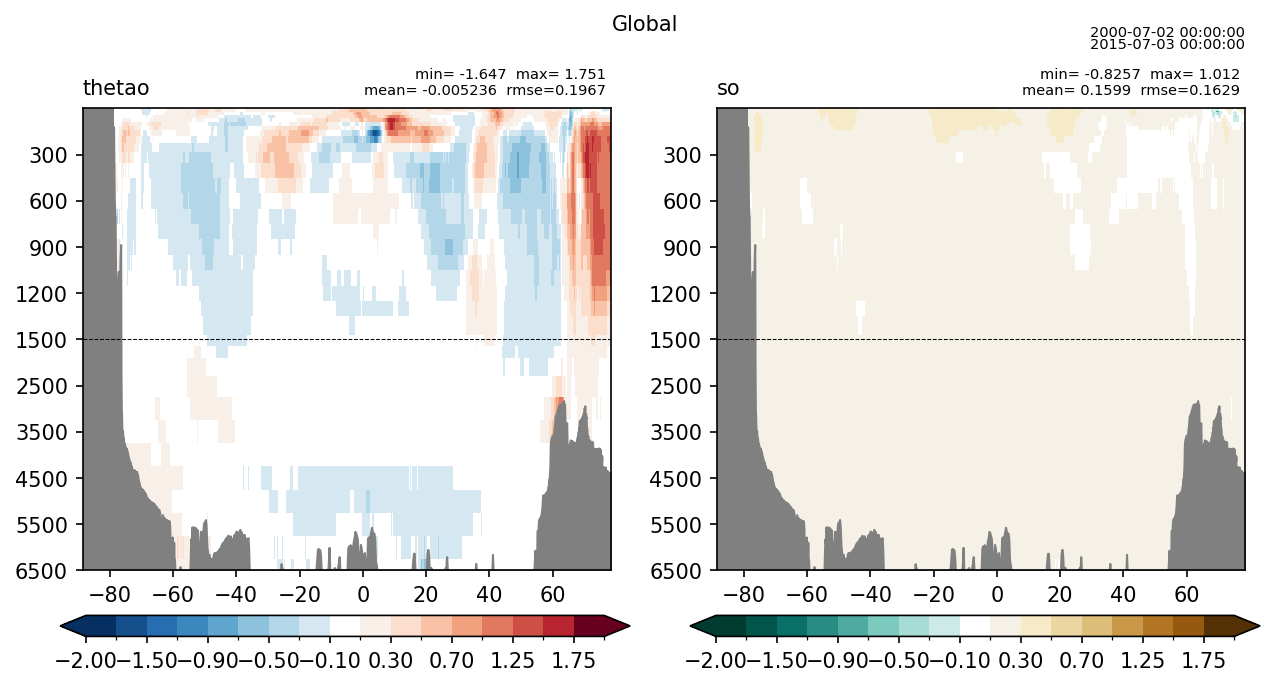

In [17]:
fig = plt.figure(figsize=(10,4),dpi=150)
ax1 = plt.subplot(1,2,1, facecolor="gray")

levels = np.array([-2.,-1.75,-1.5,-1.25] + list(np.arange(-0.9,1.1,0.2)) + [1.25,1.5,1.75,2.])
cmap, norm = cmap_normed(levels,cmap="RdBu_r", white_center=True)
cb1 = ax1.pcolormesh(y,z,tdiff, shading="auto", cmap=cmap, norm=norm)
ax1.fill_between(y,6750,depth, color="gray")
ax1.set_yscale("splitscale", zval=[6500,1500,0])
ax1.hlines(1500,y.min(),y.max(),colors="k", linestyles="dashed", linewidths=0.5)
_ = ax1.set_yticks([300,600,900,1200,1500,2500,3500,4500,5500,6500])
_ = ax1.set_xticks([-80,-60,-40,-20,0,20,40,60])

tstats,tstr = yz_stats(tdiff, y, ds.z_i)
stats_dict["thetao_global"] = tstats

ax1.text(0.99,1.03,tstr,ha="right",transform=ax1.transAxes,fontsize=7)
ax1.text(0,1.03,"thetao",ha="left",transform=ax1.transAxes,fontsize=10)

cax = fig.add_axes([0.11, 0.0, 0.38, 0.035])
fig.colorbar(cb1, cax=cax, orientation='horizontal', extend="both")

ax2 = plt.subplot(1,2,2, facecolor="gray")

levels = np.array([-2.,-1.75,-1.5,-1.25] + list(np.arange(-0.9,1.1,0.2)) + [1.25,1.5,1.75,2.])
cmap, norm = cmap_normed(levels,cmap="BrBG_r", white_center=True)
cb2 = ax2.pcolormesh(y,z,sdiff, shading="auto", cmap=cmap, norm=norm)
ax2.fill_between(y,6750,depth, color="gray")
ax2.set_yscale("splitscale", zval=[6500,1500,0])
ax2.hlines(1500,y.min(),y.max(),colors="k", linestyles="dashed", linewidths=0.5)
_ = ax2.set_yticks([300,600,900,1200,1500,2500,3500,4500,5500,6500])
_ = ax2.set_xticks([-80,-60,-40,-20,0,20,40,60])

sstats,sstr = yz_stats(sdiff, y, ds.z_i)
stats_dict["so_global"] = sstats

ax2.text(0.99,1.03,sstr,ha="right",transform=ax2.transAxes,fontsize=7)
ax2.text(0,1.03,"so",ha="left",transform=ax2.transAxes,fontsize=10)

cax = fig.add_axes([0.53, 0.0, 0.38, 0.035])
fig.colorbar(cb2, cax=cax, orientation='horizontal', extend="both")
fig.text(0.5,1.01,"Global",ha="center")

fig.text(0.9,1.00,str(start_time.values),ha="right",fontsize=7)
fig.text(0.9,0.98,str(end_time.values),ha="right",fontsize=7)

### Atlantic-Arctic

In [18]:
mask = xr.where((basins == 2) | (basins == 4), 1, np.nan)

tdiff = (diff.thetao * mask).weighted(ds.areacello).mean("xh")
sdiff = (diff.so * mask).weighted(ds.areacello).mean("xh")
depth = (diff.depth * mask).max("xh")
z = diff.z_l
y = diff.geolat.mean("xh")

Text(0.9, 0.98, '2015-07-03 00:00:00')

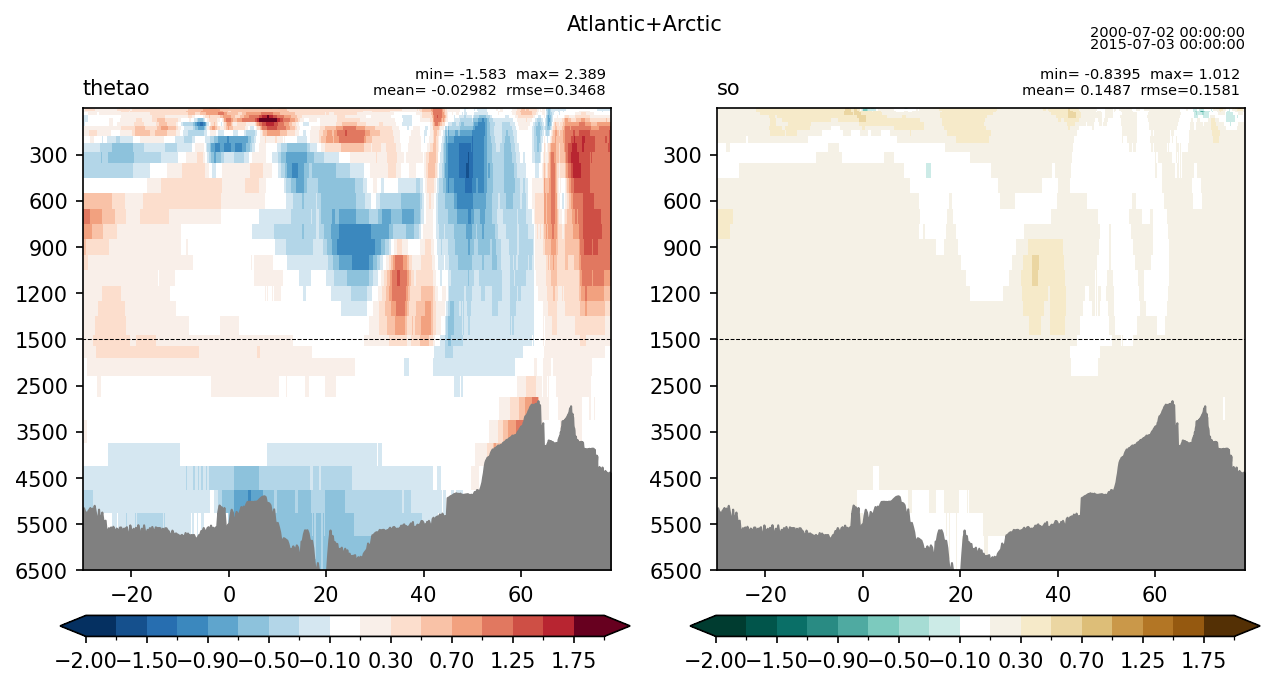

In [19]:
fig = plt.figure(figsize=(10,4),dpi=150)
ax1 = plt.subplot(1,2,1, facecolor="gray")

levels = np.array([-2.,-1.75,-1.5,-1.25] + list(np.arange(-0.9,1.1,0.2)) + [1.25,1.5,1.75,2.])
cmap, norm = cmap_normed(levels,cmap="RdBu_r", white_center=True)
cb1 = ax1.pcolormesh(y,z,tdiff, shading="auto", cmap=cmap, norm=norm)
ax1.fill_between(y,6750,depth, color="gray")
ax1.set_yscale("splitscale", zval=[6500,1500,0])
ax1.hlines(1500,y.min(),y.max(),colors="k", linestyles="dashed", linewidths=0.5)
_ = ax1.set_yticks([300,600,900,1200,1500,2500,3500,4500,5500,6500])
_ = ax1.set_xticks([-80,-60,-40,-20,0,20,40,60])

ax1.set_xlim(-30,None)

tstats,tstr = yz_stats(tdiff, y, ds.z_i)
stats_dict["thetao_atlarc"] = tstats

ax1.text(0.99,1.03,tstr,ha="right",transform=ax1.transAxes,fontsize=7)
ax1.text(0,1.03,"thetao",ha="left",transform=ax1.transAxes,fontsize=10)

cax = fig.add_axes([0.11, 0.0, 0.38, 0.035])
fig.colorbar(cb1, cax=cax, orientation='horizontal', extend="both")

ax2 = plt.subplot(1,2,2, facecolor="gray")

levels = np.array([-2.,-1.75,-1.5,-1.25] + list(np.arange(-0.9,1.1,0.2)) + [1.25,1.5,1.75,2.])
cmap, norm = cmap_normed(levels,cmap="BrBG_r", white_center=True)
cb2 = ax2.pcolormesh(y,z,sdiff, shading="auto", cmap=cmap, norm=norm)
ax2.fill_between(y,6750,depth, color="gray")
ax2.set_yscale("splitscale", zval=[6500,1500,0])
ax2.hlines(1500,y.min(),y.max(),colors="k", linestyles="dashed", linewidths=0.5)
_ = ax2.set_yticks([300,600,900,1200,1500,2500,3500,4500,5500,6500])
_ = ax2.set_xticks([-80,-60,-40,-20,0,20,40,60])

sstats,sstr = yz_stats(sdiff, y, ds.z_i)
stats_dict["so_atlarc"] = sstats

ax2.text(0.99,1.03,sstr,ha="right",transform=ax2.transAxes,fontsize=7)
ax2.text(0,1.03,"so",ha="left",transform=ax2.transAxes,fontsize=10)

cax = fig.add_axes([0.53, 0.0, 0.38, 0.035])
fig.colorbar(cb2, cax=cax, orientation='horizontal', extend="both")

ax2.set_xlim(-30,None)
fig.text(0.5,1.01,"Atlantic+Arctic",ha="center")

fig.text(0.9,1.00,str(start_time.values),ha="right",fontsize=7)
fig.text(0.9,0.98,str(end_time.values),ha="right",fontsize=7)

### Indo-Pacific

In [20]:
mask = xr.where((basins == 3) | (basins == 5), 1, np.nan)

tdiff = (diff.thetao * mask).weighted(ds.areacello).mean("xh")
sdiff = (diff.so * mask).weighted(ds.areacello).mean("xh")
depth = (diff.depth * mask).max("xh")
z = diff.z_l
y = diff.geolat.mean("xh")

Text(0.9, 0.98, '2015-07-03 00:00:00')

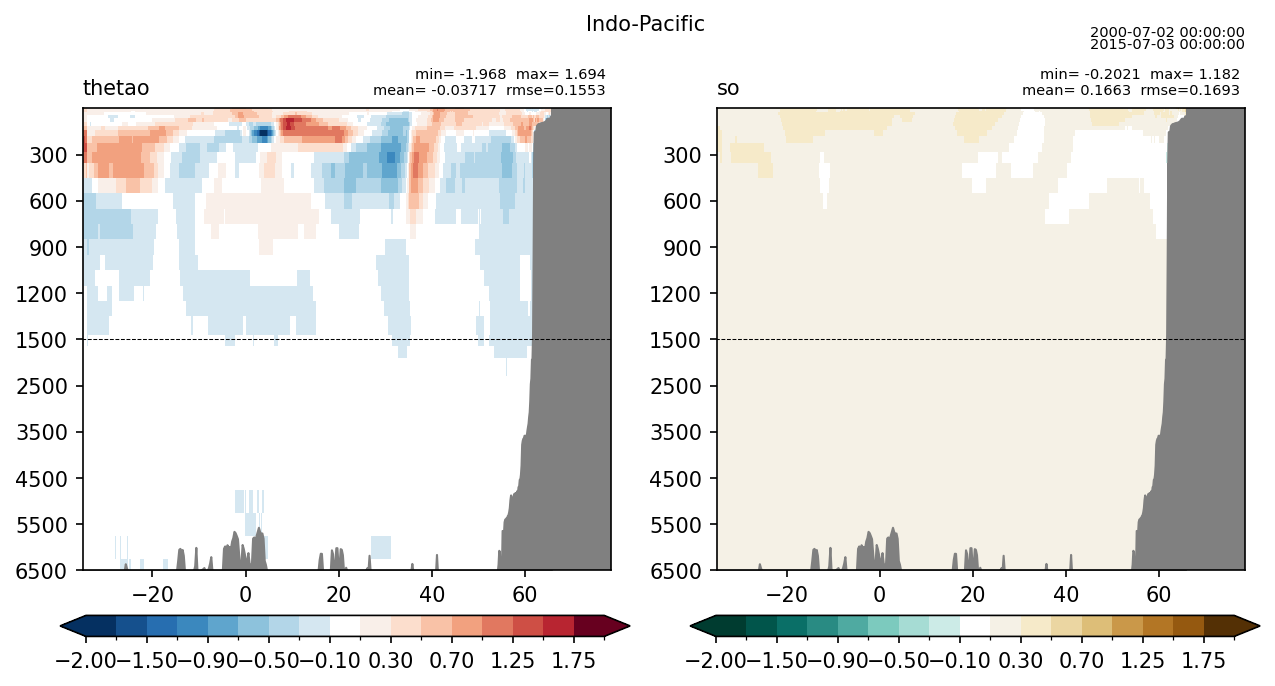

In [21]:
fig = plt.figure(figsize=(10,4),dpi=150)
ax1 = plt.subplot(1,2,1, facecolor="gray")

levels = np.array([-2.,-1.75,-1.5,-1.25] + list(np.arange(-0.9,1.1,0.2)) + [1.25,1.5,1.75,2.])
cmap, norm = cmap_normed(levels,cmap="RdBu_r", white_center=True)
cb1 = ax1.pcolormesh(y,z,tdiff, shading="auto", cmap=cmap, norm=norm)
ax1.fill_between(y,6750,depth, color="gray")
ax1.set_yscale("splitscale", zval=[6500,1500,0])
ax1.hlines(1500,y.min(),y.max(),colors="k", linestyles="dashed", linewidths=0.5)
_ = ax1.set_yticks([300,600,900,1200,1500,2500,3500,4500,5500,6500])
_ = ax1.set_xticks([-80,-60,-40,-20,0,20,40,60])

ax1.set_xlim(-35,None)

tstats,tstr = yz_stats(tdiff, y, ds.z_i)
stats_dict["thetao_indpac"] = tstats

ax1.text(0.99,1.03,tstr,ha="right",transform=ax1.transAxes,fontsize=7)
ax1.text(0,1.03,"thetao",ha="left",transform=ax1.transAxes,fontsize=10)

cax = fig.add_axes([0.11, 0.0, 0.38, 0.035])
fig.colorbar(cb1, cax=cax, orientation='horizontal', extend="both")

ax2 = plt.subplot(1,2,2, facecolor="gray")

levels = np.array([-2.,-1.75,-1.5,-1.25] + list(np.arange(-0.9,1.1,0.2)) + [1.25,1.5,1.75,2.])
cmap, norm = cmap_normed(levels,cmap="BrBG_r", white_center=True)
cb2 = ax2.pcolormesh(y,z,sdiff, shading="auto", cmap=cmap, norm=norm)
ax2.fill_between(y,6750,depth, color="gray")
ax2.set_yscale("splitscale", zval=[6500,1500,0])
ax2.hlines(1500,y.min(),y.max(),colors="k", linestyles="dashed", linewidths=0.5)
_ = ax2.set_yticks([300,600,900,1200,1500,2500,3500,4500,5500,6500])
_ = ax2.set_xticks([-80,-60,-40,-20,0,20,40,60])

sstats,sstr = yz_stats(sdiff, y, ds.z_i)
stats_dict["so_indpac"] = sstats

ax2.text(0.99,1.03,sstr,ha="right",transform=ax2.transAxes,fontsize=7)
ax2.text(0,1.03,"so",ha="left",transform=ax2.transAxes,fontsize=10)

cax = fig.add_axes([0.53, 0.0, 0.38, 0.035])
fig.colorbar(cb2, cax=cax, orientation='horizontal', extend="both")

ax2.set_xlim(-35,None)
fig.text(0.5,1.01,"Indo-Pacific",ha="center")

fig.text(0.9,1.00,str(start_time.values),ha="right",fontsize=7)
fig.text(0.9,0.98,str(end_time.values),ha="right",fontsize=7)

### Write Stats to a File

In [22]:
if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('woa13_ts.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)

metadata:
  created: '2024-09-18T16:55:58.339545'
  expName: om5_b05_Roquet_noArcticHenyey
results: {}
so_atlarc:
  bias: '0.1487'
  max: '1.012'
  min: '-0.8395'
  rmse: '0.1581'
so_global:
  bias: '0.1599'
  max: '1.012'
  min: '-0.8257'
  rmse: '0.1629'
so_indpac:
  bias: '0.1663'
  max: '1.182'
  min: '-0.2021'
  rmse: '0.1693'
thetao_atlarc:
  bias: '-0.02982'
  max: '2.389'
  min: '-1.583'
  rmse: '0.3468'
thetao_global:
  bias: '-0.005236'
  max: '1.751'
  min: '-1.647'
  rmse: '0.1967'
thetao_indpac:
  bias: '-0.03717'
  max: '1.694'
  min: '-1.968'
  rmse: '0.1553'

